<a href="https://colab.research.google.com/github/hgstyler/SEM-Denoise-Project/blob/main/GAN_practice_07272022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn # design Generator, Discriminator

from torchvision import datasets # to load MNIST image dataset
import torchvision.transforms as transforms # to pre-treatment of the loaded images
from torchvision.utils import save_image # to save resultant images

In [ ]:
# noise vector dimension, noise distribution
latent_dim = 100

# define Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # define block
        def block(input_dim, output_dim, normalize=True): # input_dim: input dimension, output_dim: output dimenstion
            # linear function
            layers = [nn.Linear(input_dim, output_dim)]
            # batch normalization
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # LeakyReLU used as an activation function
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh() # Tanh: hyperbolic tangent
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # batch size, channel, height, width
        return img

In [ ]:
# define Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(), # Sigmoid: 1 / (1 + exp(-x))
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1) # flattened represents that image tensor is transformed to vector
        output = self.model(flattened)
        return output

In [ ]:
transforms_train = transforms.Compose([
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5]) # mean=0.5, std=0.5                                       
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# learning 128 images per batch
# in raw code, num_wordker=4, but Colab's max num_workers=2.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [ ]:
# initiate Generator, Discriminator
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# loss function
adversarial_loss = nn.BCELoss() # BCE = Binary Cross-Entropy
adversarial_loss.cuda()

# learning rate
lr = 0.0002

# optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# learning rate, beta parameters are selected in widely used cases.


In [ ]:
import time

# learning epochs
n_epochs = 200

# batch interval for print
sample_interval = 2000

# start time
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # create the answer label for real and fake images
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

        real_imgs = imgs.cuda()

        ### TASK 1. Learning Generator
        # optimizer for Generator
        optimizer_G.zero_grad()

        # sampling random noise
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # create images
        generated_imgs = generator(z)

        # loss for generator
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # update generator
        g_loss.backward()
        optimizer_G.step()

        ### TASK 2. Learning Discriminator
        # optimizer for Discriminator
        optimizer_D.zero_grad()

        # loss for discriminator
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # update discriminator
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True) # select 25 generated images and save to png file (5x5)
        
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}secs]")

[Epoch 0/200] [D loss: 0.528723] [G loss: 0.608886] [Elapsed time: 14.17secs]
[Epoch 1/200] [D loss: 0.328147] [G loss: 1.499662] [Elapsed time: 28.29secs]
[Epoch 2/200] [D loss: 0.314639] [G loss: 1.154449] [Elapsed time: 43.17secs]
[Epoch 3/200] [D loss: 1.057876] [G loss: 4.318712] [Elapsed time: 57.29secs]
[Epoch 4/200] [D loss: 0.235194] [G loss: 1.754271] [Elapsed time: 71.42secs]
[Epoch 5/200] [D loss: 0.193926] [G loss: 2.460559] [Elapsed time: 85.35secs]
[Epoch 6/200] [D loss: 0.163327] [G loss: 1.727941] [Elapsed time: 99.37secs]
[Epoch 7/200] [D loss: 0.434483] [G loss: 3.201464] [Elapsed time: 113.49secs]
[Epoch 8/200] [D loss: 0.254823] [G loss: 1.575457] [Elapsed time: 127.54secs]
[Epoch 9/200] [D loss: 0.257260] [G loss: 1.954448] [Elapsed time: 141.53secs]
[Epoch 10/200] [D loss: 0.267237] [G loss: 1.426819] [Elapsed time: 155.55secs]
[Epoch 11/200] [D loss: 0.200261] [G loss: 1.744531] [Elapsed time: 170.51secs]
[Epoch 12/200] [D loss: 0.163230] [G loss: 2.026808] [Ela

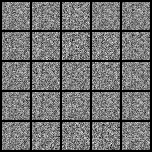

In [ ]:
from IPython.display import Image

Image('0.png')

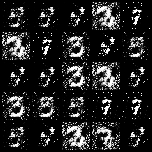

In [ ]:
Image('12000.png')

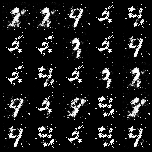

In [ ]:
Image('22000.png')

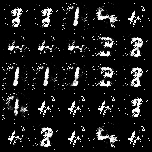

In [ ]:
Image('32000.png')

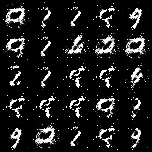

In [ ]:
Image('52000.png')

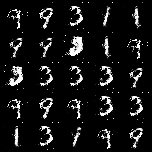

In [ ]:
Image('72000.png')

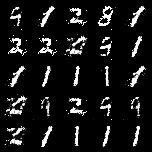

In [ ]:
Image('92000.png')